## Information

- 본 문서는 Google Colab으로 작성되었습니다. 데이터셋의 경로를 이용자에 맞게 설정해 주셔야 합니다. 
- 데이터셋은 얼굴 이미지를 직접 수집해 활용하였습니다.
- keras application에서 총 14개 모델을 load한 뒤, loss와 accuracy, 그리고 test evaluation을 종합 비교하여 3개 모델을 선정하였습니다. 


## Import & Drive Mount

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import re
from PIL import Image

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
keras.__version__

'2.5.0'

In [ ]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -l /content/drive/My\ Drive/[양재]\ 1조/dataset/age_data.zip

-rw------- 1 root root 20299135 Jun  2 14:36 '/content/drive/My Drive/[양재] 1조/dataset/age_data.zip'


## Data Preprocessing

In [ ]:
!unzip /content/drive/My\ Drive/[양재]\ 1조/dataset/age_data.zip

Archive:  /content/drive/My Drive/[양재] 1조/dataset/age_data.zip
   creating: train/
   creating: train/teen/
  inflating: train/teen/20210511154436.jpg  
  inflating: train/teen/20210511134425.jpg  
  inflating: train/teen/20210511144923.jpg  
  inflating: train/teen/20210511132803.jpg  
  inflating: train/teen/20210511162125.jpg  
  inflating: train/teen/20210511111619.jpg  
  inflating: train/teen/20210511154713.jpg  
  inflating: train/teen/20210511134410.jpg  
  inflating: train/teen/20210511140005.jpg  
  inflating: train/teen/20210511163155_rp.jpg  
  inflating: train/teen/20210511133826.jpg  
  inflating: train/teen/20210511113735.jpg  
  inflating: train/teen/20210511144707.jpg  
  inflating: train/teen/20210511163120_rp.jpg  
  inflating: train/teen/20210511140001.jpg  
  inflating: train/teen/20210511132643.jpg  
  inflating: train/teen/20210511132506.jpg  
  inflating: train/teen/20210511142539.jpg  
  inflating: train/teen/20210511163246_rp.jpg  
  inflating: train/teen/2021

### Generate Data

In [ ]:
#Gray scaling
train_dir, valid_dir = 'train/', 'valid/'

age_list = ['teen', 'young', 'adult', 'senior']
dir_sort = [train_dir, valid_dir]

for dir in dir_sort:
    for age in age_list:

        datum_path = dir + age + '/'

        for datum in os.listdir(datum_path):

            im = Image.open(datum_path + datum) 
            im.convert('L').save(datum_path + datum)

In [ ]:
#Image augmentation
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range=30,
                               horizontal_flip = True,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               brightness_range = [0.3, 0.7],
                               )

valid_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory(train_dir,
                                           target_size = (200,200),
                                           batch_size = 50,
                                           class_mode = 'categorical')

valid_data = valid_gen.flow_from_directory(valid_dir,
                                        target_size = (200,200),
                                        batch_size = 50,
                                        shuffle = False,
                                        class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 262 images belonging to 4 classes.


In [ ]:
print(f'- Train data : {len(train_data):4d} batches')
print(f'- Valid data  : {len(valid_data):4d} batches')

- Train data :   13 batches
- Valid data  :    6 batches


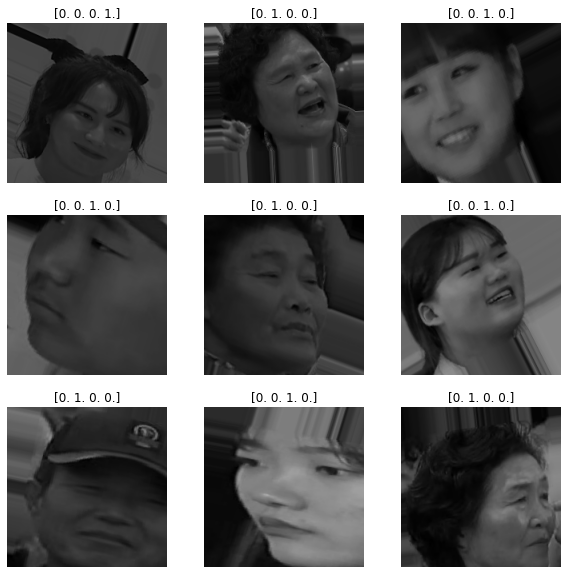

In [ ]:
#train data 시각화 (디렉토리 순서대로 0 : adult 36~59 / 1 : senior 60~ / 2 : teen 14~19 / 3 : young 20~34)
images = train_data[0][0][:9]
labels = train_data[0][1][:9]

plt.figure(figsize = (10,10))

for i in range(9) :
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis(False)

plt.show()

### test dataset


In [ ]:
!unzip /content/drive/My\ Drive/[양재]\ 1조/dataset/test.zip

Archive:  /content/drive/My Drive/[양재] 1조/dataset/test.zip
  inflating: test/남자청년.jpg   
  inflating: test/남자청소년.jpg  
  inflating: test/아저씨.jpg      
  inflating: test/아줌마.jpg      
  inflating: test/여자청년.jpg   
  inflating: test/여자청소년.jpg  
  inflating: test/할머니.jpg      
  inflating: test/할아버지.jpg   


## define function

### loss & accuracy visualization

In [ ]:
def draw_graph(hist):
  plt.figure(figsize = (16,6))
  
  #loss
  plt.subplot(1,2,1)
  plt.plot(hist.epoch, hist.history['loss'], label = 'Train')
  plt.plot(hist.epoch, hist.history['val_loss'], label = 'Valid')
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Train & Valid Loss')
  plt.legend()
  
  #accuracy
  plt.subplot(1,2,2)
  plt.plot(hist.epoch, hist.history['accuracy'], label = 'Train')
  plt.plot(hist.epoch, hist.history['val_accuracy'], label = 'Valid')
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train & Valid Accuracy')
  plt.legend()

  plt.show()

### evaluate test data

In [ ]:
#test 파일 리스트업
path = 'test/'
file_list = os.listdir(path)

label_text = ['adult','senior','teen','young']

In [ ]:
#시각화
import cv2
import random

def softmax(x): 
  m = np.max(x)
  sm = np.exp(x - m)/np.sum(np.exp(x - m)) 
  return sm

def evaluate_testdata(model):

  plt.figure(figsize = (8, 16))

  for n in range(len(file_list)):
    #이미지 경로 추출 
    image_path = 'test/' + file_list[n]

    #이미지 출력 
    plt.subplot(8 , 2, n * 2 + 1) 
    plt.imshow(plt.imread(image_path)) 
    plt.axis('off')

    #Top 예측값 출력 공간 
    plt.subplot(8 , 2 , n * 2 + 2)

    #이미지 크기 변경 및 정규화 
    img = cv2.imread(image_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize = (200, 200))  # target size와 동일하게 변경
    img = img / 255.0
    img = np.expand_dims(img, axis = 0)

    #이미지 분류 
    logits = model.predict(img)[0] 
    prediction = softmax(logits)

    #예측값
    predict = prediction.argsort()[::-1][:] 
    labels = [label_text[index] for index in predict]
    
    #Top 막대그래프 출력 
    plt.barh(range(4), prediction[predict][::-1] * 100) 
    plt.yticks(range(4), labels[::-1])

## VGG16

### Modeling

In [ ]:
#import VGG16
from keras.applications.vgg16 import VGG16

conv_base = VGG16(include_top = False,
                  input_shape = (200, 200, 3))

#model definition
from keras import models, layers, regularizers

#CNN-VGG16
model_V = models.Sequential()
model_V.add(conv_base)

#DNN
model_V.add(layers.Flatten())
model_V.add(layers.Dense(256, activation = 'relu'))
model_V.add(layers.Dropout(0.2))
model_V.add(layers.Dense(64, activation = 'relu'))
model_V.add(layers.BatchNormalization())
model_V.add(layers.Dense(4, activation = 'softmax'))

model_V.summary()

#model compiling
from keras import optimizers

model_V.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________

In [ ]:
#model fitting 
%%time

hist_V = model_V.fit(train_data,
                 epochs = 100,
                 validation_data = valid_data)

Epoch 1/10
13/13 [==============================] - 8s 608ms/step - loss: 0.2799 - accuracy: 0.9021 - val_loss: 0.7458 - val_accuracy: 0.7672
Epoch 2/10
13/13 [==============================] - 7s 561ms/step - loss: 0.2401 - accuracy: 0.9184 - val_loss: 0.8397 - val_accuracy: 0.7748
Epoch 3/10
13/13 [==============================] - 7s 553ms/step - loss: 0.2590 - accuracy: 0.8989 - val_loss: 0.7796 - val_accuracy: 0.7519
Epoch 4/10
13/13 [==============================] - 7s 561ms/step - loss: 0.2413 - accuracy: 0.9119 - val_loss: 0.7163 - val_accuracy: 0.7748
Epoch 5/10
13/13 [==============================] - 8s 567ms/step - loss: 0.2472 - accuracy: 0.9070 - val_loss: 0.7957 - val_accuracy: 0.7634
Epoch 6/10
13/13 [==============================] - 7s 563ms/step - loss: 0.2128 - accuracy: 0.9152 - val_loss: 0.7541 - val_accuracy: 0.7672
Epoch 7/10
13/13 [==============================] - 7s 556ms/step - loss: 0.2330 - accuracy: 0.9233 - val_loss: 0.7255 - val_accuracy: 0.7634
Epoch 

### Evaluation

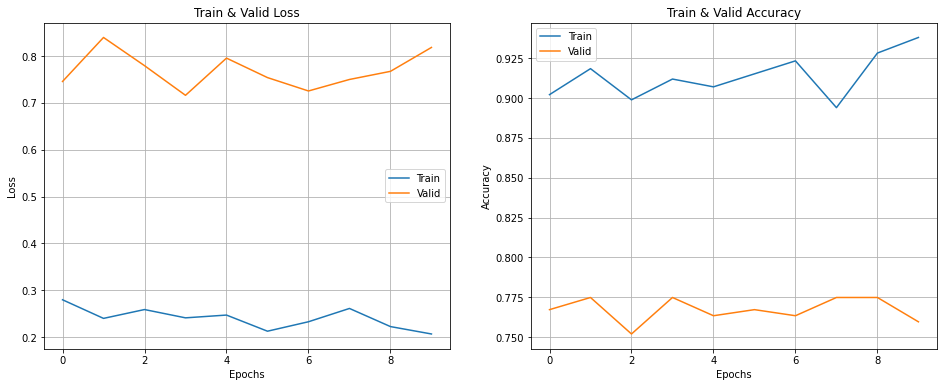

In [ ]:
#loss & accuracy visualization
draw_graph(hist_V)

In [ ]:
#model evaluation
loss_V, acc_V = model_V.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_V:.5f}')

print('\n* Accuracy')
print(f'==> {acc_V:.5f}')

6/6 [==============================] - 1s 86ms/step - loss: 0.8185 - accuracy: 0.7595

* Loss
==> 0.81847

* Accuracy
==> 0.75954


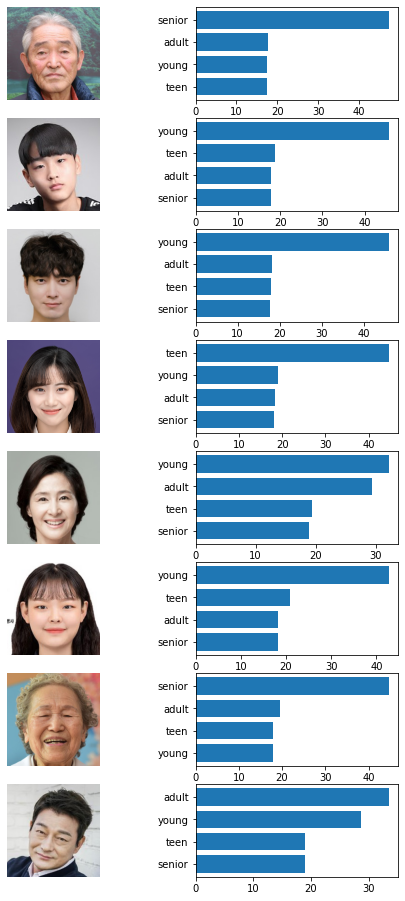

In [ ]:
#test visualization
evaluate_testdata(model_V)

## VGG19

### Modeling

In [ ]:
#import VGG19 
from keras.applications.vgg19 import VGG19

conv_base = VGG19(include_top = False, 
                  input_shape = (200, 200, 3))

#model definition
from keras import models, layers, regularizers

#CNN-VGG19
model_V19 = models.Sequential()
model_V19.add(conv_base)

#DNN
model_V19.add(layers.Flatten())
model_V19.add(layers.Dense(256, activation = 'relu'))
model_V19.add(layers.Dropout(0.2))
model_V19.add(layers.Dense(64, activation = 'relu'))
model_V19.add(layers.BatchNormalization())
model_V19.add(layers.Dense(4, activation = 'softmax'))

model_V19.summary()

#model compiling
from keras import optimizers

model_V19.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________

In [ ]:
#model fitting 
%%time

hist_V19 = model_V19.fit(train_data,
                 epochs = 100,
                 validation_data = valid_data)

Epoch 1/5
13/13 [==============================] - 11s 808ms/step - loss: 0.4683 - accuracy: 0.8206 - val_loss: 0.8435 - val_accuracy: 0.7137
Epoch 2/5
13/13 [==============================] - 11s 822ms/step - loss: 0.5450 - accuracy: 0.7814 - val_loss: 0.7373 - val_accuracy: 0.7519
Epoch 3/5
13/13 [==============================] - 11s 892ms/step - loss: 0.4905 - accuracy: 0.8010 - val_loss: 0.6836 - val_accuracy: 0.7481
Epoch 4/5
13/13 [==============================] - 11s 834ms/step - loss: 0.4862 - accuracy: 0.8059 - val_loss: 0.6232 - val_accuracy: 0.7519
Epoch 5/5
13/13 [==============================] - 11s 817ms/step - loss: 0.4451 - accuracy: 0.8385 - val_loss: 0.6392 - val_accuracy: 0.7672
CPU times: user 1min 12s, sys: 1.17 s, total: 1min 13s
Wall time: 1min 5s


### Evaluation

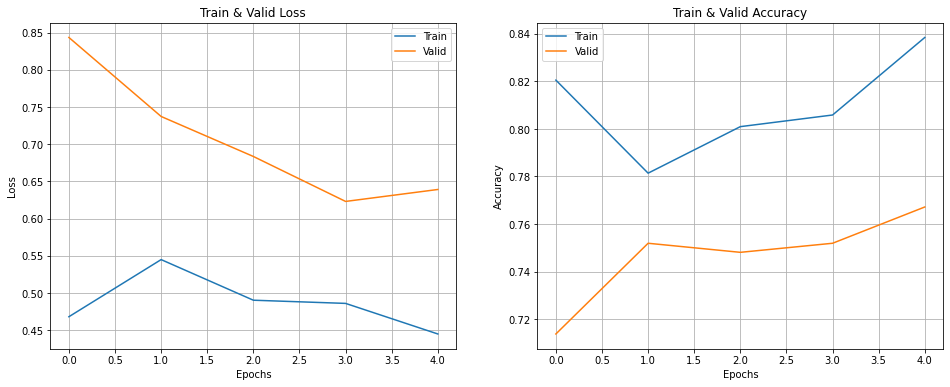

In [ ]:
#loss & accuracy visualization
draw_graph(hist_V19)

In [ ]:
#model evaluation
loss_V19, acc_V19 = model_V19.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_V19:.5f}')

print('\n* Accuracy')
print(f'==> {acc_V19:.5f}')

6/6 [==============================] - 1s 207ms/step - loss: 0.6392 - accuracy: 0.7672

* Loss
==> 0.63922

* Accuracy
==> 0.76718


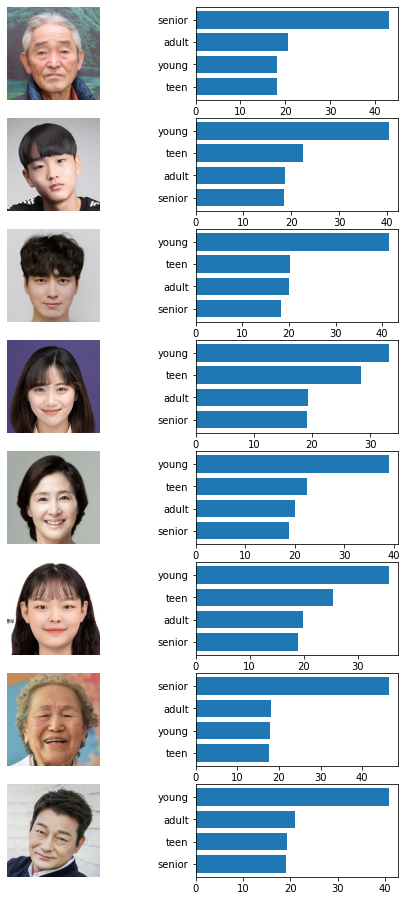

In [ ]:
#test visualization
evaluate_testdata(model_V19)



## DenseNet201

### Modeling

In [ ]:
#import DenseNet201
from keras.applications.densenet import DenseNet201

conv_base = DenseNet201(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-DenseNet169
model_D201 = models.Sequential()
model_D201.add(conv_base)

#DNN
model_D201.add(layers.Flatten())
model_D201.add(layers.Dense(256, activation = 'relu'))
model_D201.add(layers.Dropout(0.2))
model_D201.add(layers.Dense(64, activation = 'relu'))
model_D201.add(layers.BatchNormalization())
model_D201.add(layers.Dense(4, activation = 'softmax'))

model_D201.summary()

#model compiling
from keras import optimizers

model_D201.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

74850304/74836368 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 69120)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               17694976  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________

In [ ]:
#model fitting 
%%time

hist_D201 = model_D201.fit(train_data,
                 epochs = 70,
                 validation_data = valid_data)

Epoch 1/70
13/13 [==============================] - 166s 4s/step - loss: 2.0177 - accuracy: 0.2375 - val_loss: 1.5501 - val_accuracy: 0.2939
Epoch 2/70
13/13 [==============================] - 21s 2s/step - loss: 1.7306 - accuracy: 0.3202 - val_loss: 1.5573 - val_accuracy: 0.3244
Epoch 3/70
13/13 [==============================] - 21s 2s/step - loss: 1.7765 - accuracy: 0.2578 - val_loss: 1.5815 - val_accuracy: 0.3588
Epoch 4/70
13/13 [==============================] - 20s 2s/step - loss: 1.4913 - accuracy: 0.3695 - val_loss: 1.5835 - val_accuracy: 0.3893
Epoch 5/70
13/13 [==============================] - 21s 2s/step - loss: 1.3734 - accuracy: 0.4367 - val_loss: 1.6064 - val_accuracy: 0.3702
Epoch 6/70
13/13 [==============================] - 21s 2s/step - loss: 1.3645 - accuracy: 0.4386 - val_loss: 1.5876 - val_accuracy: 0.3626
Epoch 7/70
13/13 [==============================] - 21s 2s/step - loss: 1.2757 - accuracy: 0.4687 - val_loss: 1.5467 - val_accuracy: 0.3817
Epoch 8/70
13/13 [=

### Evaluation

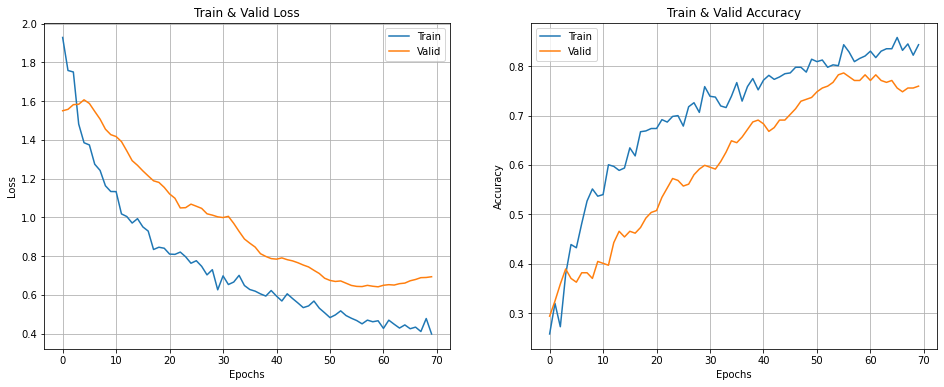

In [ ]:
#loss & accuracy visualization
draw_graph(hist_D201)

In [ ]:
#model evaluation
loss_D201, acc_D201 = model_D201.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_D201:.5f}')

print('\n* Accuracy')
print(f'==> {acc_D201:.5f}')

6/6 [==============================] - 2s 350ms/step - loss: 0.6936 - accuracy: 0.7595

* Loss
==> 0.69361

* Accuracy
==> 0.75954


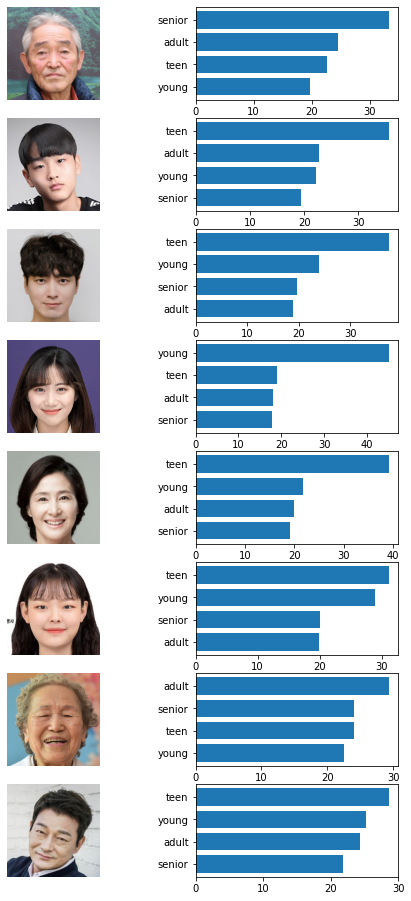

In [ ]:
#test visualization
evaluate_testdata(model_D201)

## ResNet152

### Modeling

In [ ]:
#import ResNet101
from keras.applications.resnet import ResNet152

conv_base = ResNet152(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-ResNet50
model_R152 = models.Sequential()
model_R152.add(conv_base)

#DNN
model_R152.add(layers.Flatten())
model_R152.add(layers.Dense(256, activation = 'relu'))
model_R152.add(layers.Dropout(0.2))
model_R152.add(layers.Dense(64, activation = 'relu'))
model_R152.add(layers.BatchNormalization())
model_R152.add(layers.Dense(4, activation = 'softmax'))

model_R152.summary()

#model compiling
from keras import optimizers

model_R152.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

234708992/234698864 [==============================] - 5s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_207 (Bat (None, 64)                256       
_____________________________________________________

In [ ]:
#model fitting 
%%time

hist_R152 = model_R152.fit(train_data,
                 epochs = 100,
                 validation_data = valid_data)

Epoch 1/50
13/13 [==============================] - 17s 1s/step - loss: 0.4885 - accuracy: 0.8108 - val_loss: 1.2919 - val_accuracy: 0.5076
Epoch 2/50
13/13 [==============================] - 18s 1s/step - loss: 0.4501 - accuracy: 0.8075 - val_loss: 1.2497 - val_accuracy: 0.5458
Epoch 3/50
13/13 [==============================] - 17s 1s/step - loss: 0.4740 - accuracy: 0.8352 - val_loss: 1.1938 - val_accuracy: 0.5725
Epoch 4/50
13/13 [==============================] - 17s 1s/step - loss: 0.4397 - accuracy: 0.8271 - val_loss: 1.1455 - val_accuracy: 0.5916
Epoch 5/50
13/13 [==============================] - 17s 1s/step - loss: 0.4449 - accuracy: 0.8352 - val_loss: 1.1519 - val_accuracy: 0.5725
Epoch 6/50
13/13 [==============================] - 17s 1s/step - loss: 0.4311 - accuracy: 0.8467 - val_loss: 1.1298 - val_accuracy: 0.5954
Epoch 7/50
13/13 [==============================] - 17s 1s/step - loss: 0.4512 - accuracy: 0.8320 - val_loss: 1.0733 - val_accuracy: 0.5954
Epoch 8/50
13/13 [==

### Evaluation

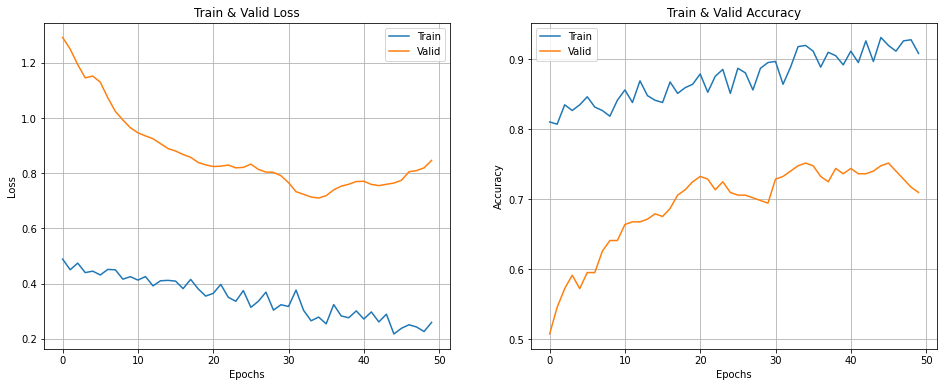

In [ ]:
#loss & accuracy visualization
draw_graph(hist_R152)

In [ ]:
#model evaluation
loss_R152, acc_R152 = model_R152.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_R152:.5f}')

print('\n* Accuracy')
print(f'==> {acc_R152:.5f}')

6/6 [==============================] - 2s 319ms/step - loss: 0.8463 - accuracy: 0.7099

* Loss
==> 0.84630

* Accuracy
==> 0.70992


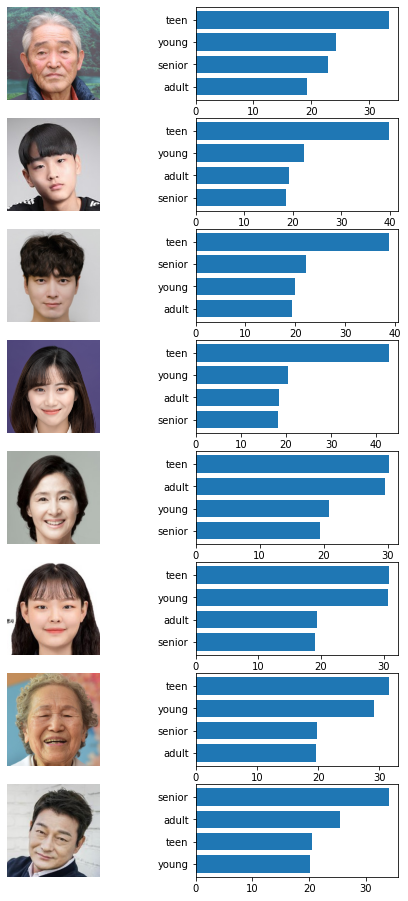

In [ ]:
#test visualization
evaluate_testdata(model_R152)

## InceptionResNetV2

### Modeling

In [ ]:
#import InceptionResNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2

conv_base = InceptionResNetV2(include_top = False,
                              input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-InceptionResNetV2
model_IR = models.Sequential()
model_IR.add(conv_base)

#DNN
model_IR.add(layers.Flatten())
model_IR.add(layers.Dense(256, activation = 'relu'))
model_IR.add(layers.Dropout(0.2))
model_IR.add(layers.Dense(64, activation = 'relu'))
model_IR.add(layers.BatchNormalization())
model_IR.add(layers.Dense(4, activation = 'softmax'))

model_IR.summary()

#model compiling
from keras import optimizers

model_IR.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

219070464/219055592 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               6291712   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_205 (Bat (None, 64)                256       
_____________________________________________________

In [ ]:
#model fitting 
%%time

hist_IR = model_IR.fit(train_data,
                 epochs = 200,
                 validation_data = valid_data)

Epoch 1/50
13/13 [==============================] - 10s 765ms/step - loss: 0.6312 - accuracy: 0.7553 - val_loss: 0.7571 - val_accuracy: 0.6832
Epoch 2/50
13/13 [==============================] - 10s 771ms/step - loss: 0.6054 - accuracy: 0.7520 - val_loss: 0.7524 - val_accuracy: 0.6947
Epoch 3/50
13/13 [==============================] - 10s 770ms/step - loss: 0.6211 - accuracy: 0.7374 - val_loss: 0.7484 - val_accuracy: 0.6947
Epoch 4/50
13/13 [==============================] - 10s 767ms/step - loss: 0.5827 - accuracy: 0.7781 - val_loss: 0.7487 - val_accuracy: 0.6985
Epoch 5/50
13/13 [==============================] - 10s 765ms/step - loss: 0.6507 - accuracy: 0.7455 - val_loss: 0.7489 - val_accuracy: 0.6832
Epoch 6/50
13/13 [==============================] - 10s 762ms/step - loss: 0.5836 - accuracy: 0.7814 - val_loss: 0.7479 - val_accuracy: 0.6908
Epoch 7/50
13/13 [==============================] - 10s 763ms/step - loss: 0.5954 - accuracy: 0.7667 - val_loss: 0.7496 - val_accuracy: 0.7023

### Evaluation

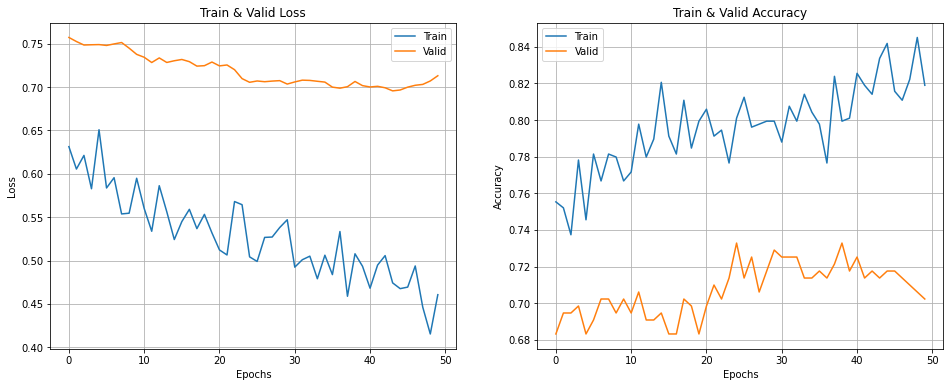

In [ ]:
#loss & accuracy visualization
draw_graph(hist_IR)

In [ ]:
#model evaluation
loss_IR, acc_IR = model_IR.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_IR:.5f}')

print('\n* Accuracy')
print(f'==> {acc_IR:.5f}')

6/6 [==============================] - 1s 175ms/step - loss: 0.7130 - accuracy: 0.7023

* Loss
==> 0.71296

* Accuracy
==> 0.70229


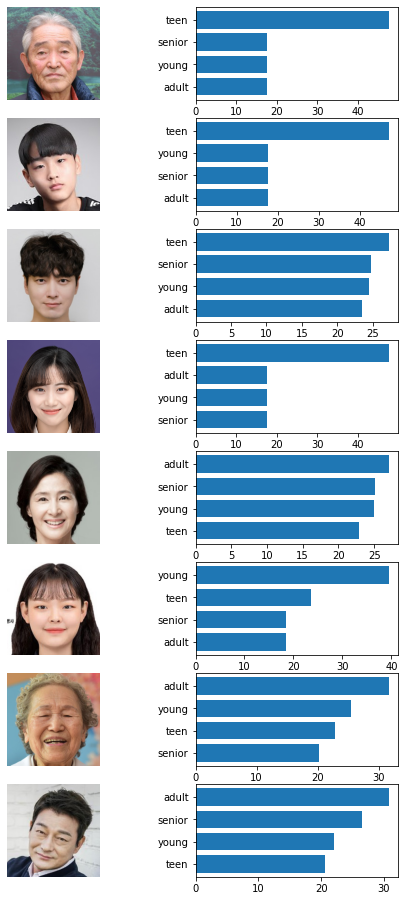

In [ ]:
#test visualization
evaluate_testdata(model_IR)

## ResNet101V2

### Modeling

In [ ]:
#import ResNet101V2
from keras.applications.resnet_v2 import ResNet101V2

conv_base = ResNet101V2(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-ResNet101V2
model_R101V2 = models.Sequential()
model_R101V2.add(conv_base)

#DNN
model_R101V2.add(layers.Flatten())
model_R101V2.add(layers.Dense(256, activation = 'relu'))
model_R101V2.add(layers.Dropout(0.2))
model_R101V2.add(layers.Dense(64, activation = 'relu'))
model_R101V2.add(layers.BatchNormalization())
model_R101V2.add(layers.Dense(4, activation = 'softmax'))

model_R101V2.summary()

#model compiling
from keras import optimizers

model_R101V2.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

171327488/171317808 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_208 (Bat (None, 64)                256       
_____________________________________________________

In [ ]:
#model fitting 
%%time

hist_R101V2 = model_R101V2.fit(train_data,
                 epochs = 70,
                 validation_data = valid_data)

Epoch 1/70
13/13 [==============================] - 46s 2s/step - loss: 1.9512 - accuracy: 0.2224 - val_loss: 1.7014 - val_accuracy: 0.3206
Epoch 2/70
13/13 [==============================] - 12s 872ms/step - loss: 1.7930 - accuracy: 0.2621 - val_loss: 1.6109 - val_accuracy: 0.3130
Epoch 3/70
13/13 [==============================] - 12s 886ms/step - loss: 1.7061 - accuracy: 0.3312 - val_loss: 1.5428 - val_accuracy: 0.3473
Epoch 4/70
13/13 [==============================] - 12s 865ms/step - loss: 1.4956 - accuracy: 0.3904 - val_loss: 1.4816 - val_accuracy: 0.3588
Epoch 5/70
13/13 [==============================] - 11s 855ms/step - loss: 1.3741 - accuracy: 0.4034 - val_loss: 1.4289 - val_accuracy: 0.3969
Epoch 6/70
13/13 [==============================] - 11s 848ms/step - loss: 1.3582 - accuracy: 0.4241 - val_loss: 1.3431 - val_accuracy: 0.4656
Epoch 7/70
13/13 [==============================] - 11s 847ms/step - loss: 1.3124 - accuracy: 0.4768 - val_loss: 1.2573 - val_accuracy: 0.4924
Ep

### Evaluation

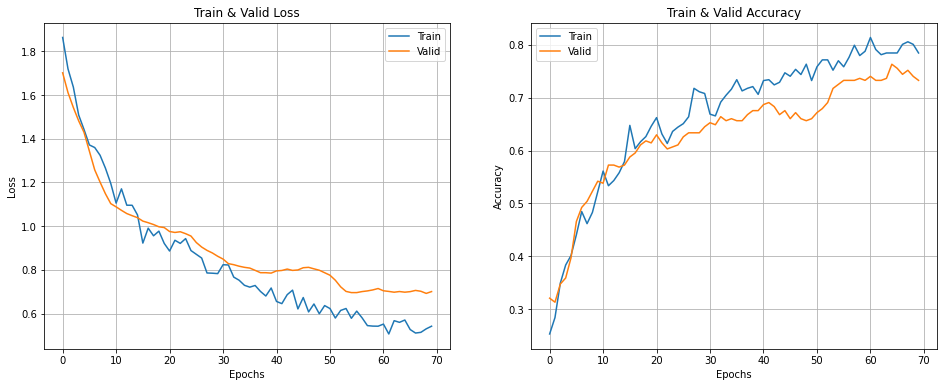

In [ ]:
#loss & accuracy visualization
draw_graph(hist_R101V2)

In [ ]:
#model evaluation
loss_R101V2, acc_R101V2 = model_R101V2.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_R101V2:.5f}')

print('\n* Accuracy')
print(f'==> {acc_R101V2:.5f}')

6/6 [==============================] - 1s 207ms/step - loss: 0.7005 - accuracy: 0.7328

* Loss
==> 0.70049

* Accuracy
==> 0.73282


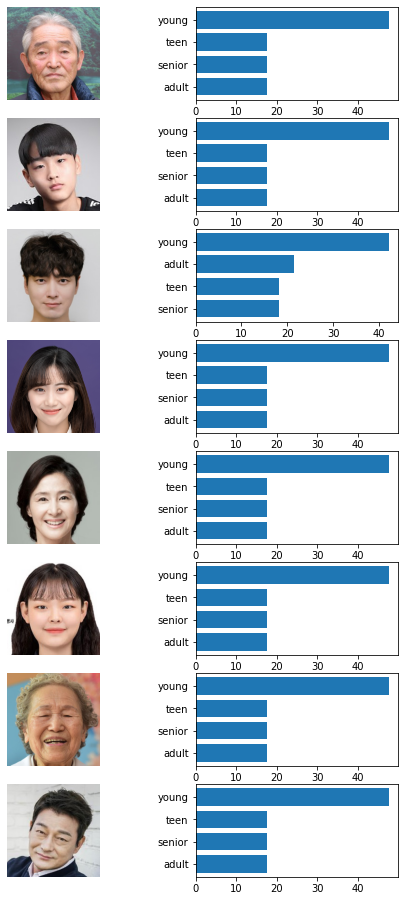

In [ ]:
#test visualization
evaluate_testdata(model_R101V2)



## DenseNet169

### Modeling

In [ ]:
#import DenseNet169
from keras.applications.densenet import DenseNet169

conv_base = DenseNet169(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-DenseNet169
model_D169 = models.Sequential()
model_D169.add(conv_base)

#DNN
model_D169.add(layers.Flatten())
model_D169.add(layers.Dense(256, activation = 'relu'))
model_D169.add(layers.Dropout(0.2))
model_D169.add(layers.Dense(64, activation = 'relu'))
model_D169.add(layers.BatchNormalization())
model_D169.add(layers.Dense(4, activation = 'softmax'))

model_D169.summary()

#model compiling
from keras import optimizers

model_D169.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

51888128/51877672 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 6, 6, 1664)        12642880  
_________________________________________________________________
flatten_5 (Flatten)          (None, 59904)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               15335680  
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_103 (Bat (None, 64)                256       
_______________________________________________________

In [ ]:
#model fitting 
%%time

hist_D169 = model_D169.fit(train_data,
                 epochs = 100,
                 validation_data = valid_data)

Epoch 1/100
13/13 [==============================] - 66s 2s/step - loss: 1.7522 - accuracy: 0.2918 - val_loss: 1.6465 - val_accuracy: 0.3015
Epoch 2/100
13/13 [==============================] - 9s 756ms/step - loss: 1.8683 - accuracy: 0.2905 - val_loss: 1.5901 - val_accuracy: 0.2939
Epoch 3/100
13/13 [==============================] - 10s 715ms/step - loss: 1.5306 - accuracy: 0.3996 - val_loss: 1.5534 - val_accuracy: 0.3397
Epoch 4/100
13/13 [==============================] - 10s 710ms/step - loss: 1.5005 - accuracy: 0.4077 - val_loss: 1.5357 - val_accuracy: 0.3511
Epoch 5/100
13/13 [==============================] - 10s 713ms/step - loss: 1.4448 - accuracy: 0.4044 - val_loss: 1.5338 - val_accuracy: 0.3588
Epoch 6/100
13/13 [==============================] - 10s 711ms/step - loss: 1.3800 - accuracy: 0.4305 - val_loss: 1.5489 - val_accuracy: 0.3511
Epoch 7/100
13/13 [==============================] - 10s 713ms/step - loss: 1.2711 - accuracy: 0.5005 - val_loss: 1.5365 - val_accuracy: 0.3

### Evaluation

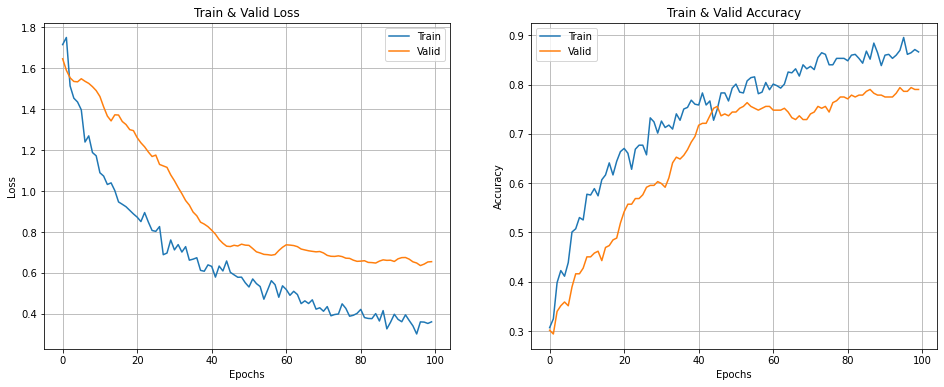

In [ ]:
#loss & accuracy visualization
draw_graph(hist_D169)

In [ ]:
#model evaluation
loss_D169, acc_D169 = model_D169.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_D169:.5f}')

print('\n* Accuracy')
print(f'==> {acc_D169:.5f}')

6/6 [==============================] - 1s 141ms/step - loss: 0.6549 - accuracy: 0.7901

* Loss
==> 0.65492

* Accuracy
==> 0.79008


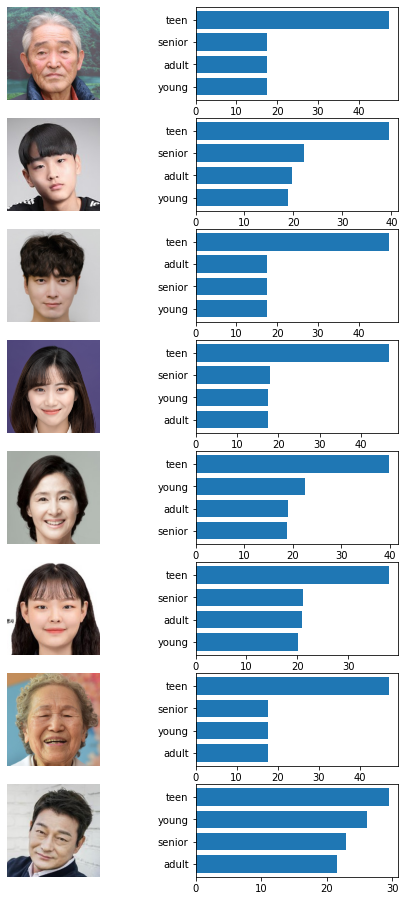

In [ ]:
#test visualization
evaluate_testdata(model_D169)



## DenseNet121

### Modeling

In [ ]:
#import DenseNet121
from keras.applications.densenet import DenseNet121

conv_base = DenseNet121(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-DenseNet121
model_D121 = models.Sequential()
model_D121.add(conv_base)

#DNN
model_D121.add(layers.Flatten())
model_D121.add(layers.Dense(256, activation = 'relu'))
model_D121.add(layers.Dropout(0.2))
model_D121.add(layers.Dense(64, activation = 'relu'))
model_D121.add(layers.BatchNormalization())
model_D121.add(layers.Dense(4, activation = 'softmax'))

model_D121.summary()

#model compiling
from keras import optimizers

model_D121.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 6, 6, 1024)        7037504   
_________________________________________________________________
flatten_2 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               9437440   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_______________________________________________________

In [ ]:
#model fitting 
%%time

hist_D121 = model_D121.fit(train_data,
                 epochs = 100,
                 validation_data = valid_data)

Epoch 1/30
13/13 [==============================] - 9s 648ms/step - loss: 0.5115 - accuracy: 0.8059 - val_loss: 0.5807 - val_accuracy: 0.7786
Epoch 2/30
13/13 [==============================] - 9s 648ms/step - loss: 0.5417 - accuracy: 0.8042 - val_loss: 0.5781 - val_accuracy: 0.7748
Epoch 3/30
13/13 [==============================] - 9s 658ms/step - loss: 0.5556 - accuracy: 0.7684 - val_loss: 0.5777 - val_accuracy: 0.7748
Epoch 4/30
13/13 [==============================] - 9s 653ms/step - loss: 0.5086 - accuracy: 0.8059 - val_loss: 0.5788 - val_accuracy: 0.7672
Epoch 5/30
13/13 [==============================] - 9s 646ms/step - loss: 0.5049 - accuracy: 0.7879 - val_loss: 0.5807 - val_accuracy: 0.7672
Epoch 6/30
13/13 [==============================] - 9s 645ms/step - loss: 0.5347 - accuracy: 0.7945 - val_loss: 0.5806 - val_accuracy: 0.7748
Epoch 7/30
13/13 [==============================] - 9s 647ms/step - loss: 0.5048 - accuracy: 0.8059 - val_loss: 0.5796 - val_accuracy: 0.7672
Epoch 

### Evaluation

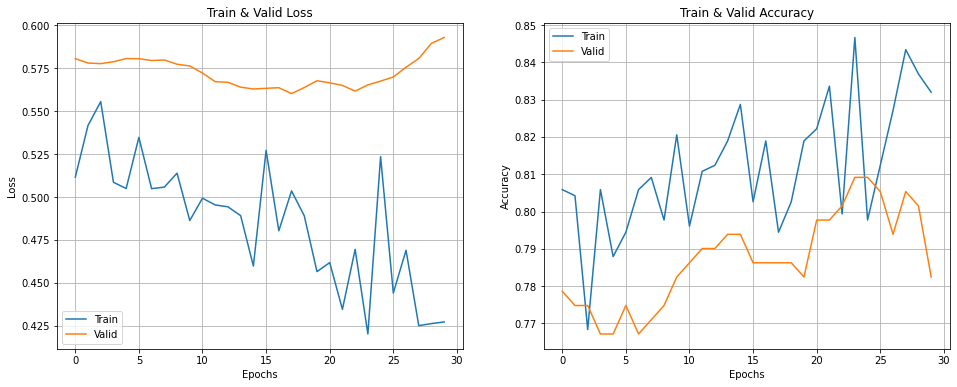

In [ ]:
#loss & accuracy visualization
draw_graph(hist_D121)

In [ ]:
#model evaluation
loss_D121, acc_D121 = model_D121.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_D121:.5f}')

print('\n* Accuracy')
print(f'==> {acc_D121:.5f}')

6/6 [==============================] - 1s 115ms/step - loss: 0.5930 - accuracy: 0.7824

* Loss
==> 0.59300

* Accuracy
==> 0.78244


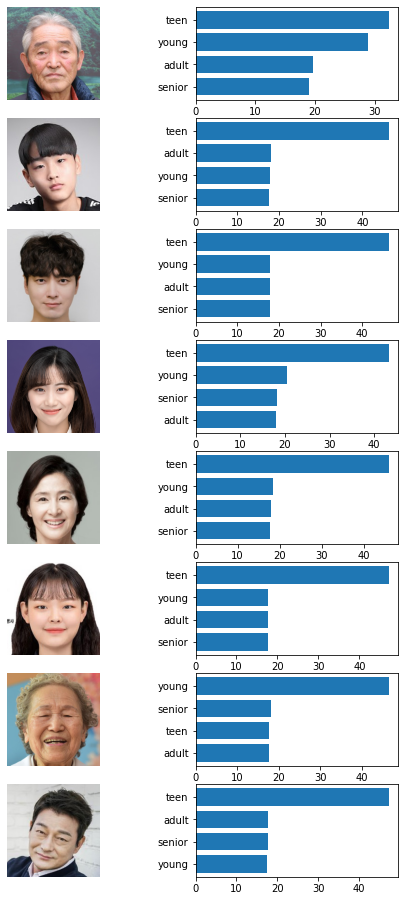

In [ ]:
#test visualization
evaluate_testdata(model_D121)

## ResNet152V2

### Modeling

In [ ]:
#import ResNet101
from keras.applications.resnet_v2 import ResNet152V2

conv_base = ResNet152V2(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-ResNet50
model_R152V2 = models.Sequential()
model_R152V2.add(conv_base)

#DNN
model_R152V2.add(layers.Flatten())
model_R152V2.add(layers.Dense(256, activation = 'relu'))
model_R152V2.add(layers.Dropout(0.2))
model_R152V2.add(layers.Dense(64, activation = 'relu'))
model_R152V2.add(layers.BatchNormalization())
model_R152V2.add(layers.Dense(4, activation = 'softmax'))

model_R152V2.summary()

#model compiling
from keras import optimizers

model_R152V2.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

234561536/234545216 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_______________________________________________________

In [ ]:
#model fitting 
%%time

hist_R152V2 = model_R152V2.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

Epoch 1/50
13/13 [==============================] - 16s 1s/step - loss: 0.3381 - accuracy: 0.8695 - val_loss: 0.6973 - val_accuracy: 0.7290
Epoch 2/50
13/13 [==============================] - 16s 1s/step - loss: 0.3475 - accuracy: 0.8793 - val_loss: 0.6906 - val_accuracy: 0.7290
Epoch 3/50
13/13 [==============================] - 16s 1s/step - loss: 0.4015 - accuracy: 0.8434 - val_loss: 0.6880 - val_accuracy: 0.7290
Epoch 4/50
13/13 [==============================] - 16s 1s/step - loss: 0.3452 - accuracy: 0.8744 - val_loss: 0.6746 - val_accuracy: 0.7328
Epoch 5/50
13/13 [==============================] - 16s 1s/step - loss: 0.3508 - accuracy: 0.8760 - val_loss: 0.6689 - val_accuracy: 0.7366
Epoch 6/50
13/13 [==============================] - 16s 1s/step - loss: 0.3697 - accuracy: 0.8728 - val_loss: 0.6705 - val_accuracy: 0.7481
Epoch 7/50
13/13 [==============================] - 16s 1s/step - loss: 0.4053 - accuracy: 0.8385 - val_loss: 0.6626 - val_accuracy: 0.7672
Epoch 8/50
13/13 [==

### Evaluation

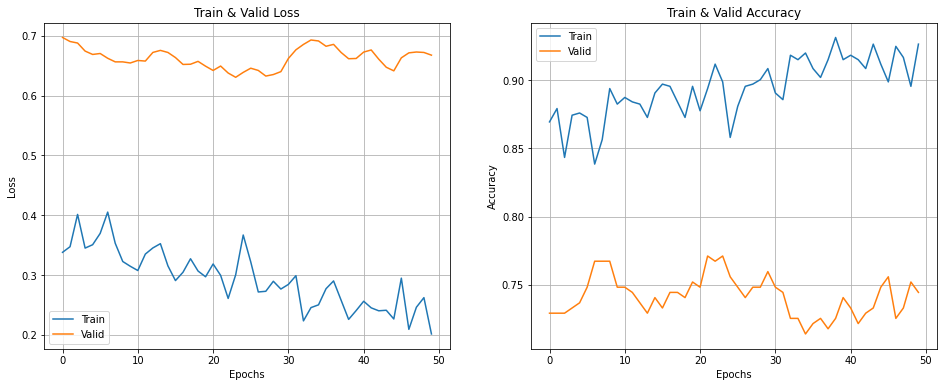

In [ ]:
#loss & accuracy visualization
draw_graph(hist_R152V2)

In [ ]:
#model evaluation
loss_R152V2, acc_R152V2 = model_R152V2.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_R152V2:.5f}')

print('\n* Accuracy')
print(f'==> {acc_R152V2:.5f}')

6/6 [==============================] - 2s 280ms/step - loss: 0.6678 - accuracy: 0.7443

* Loss
==> 0.66775

* Accuracy
==> 0.74427


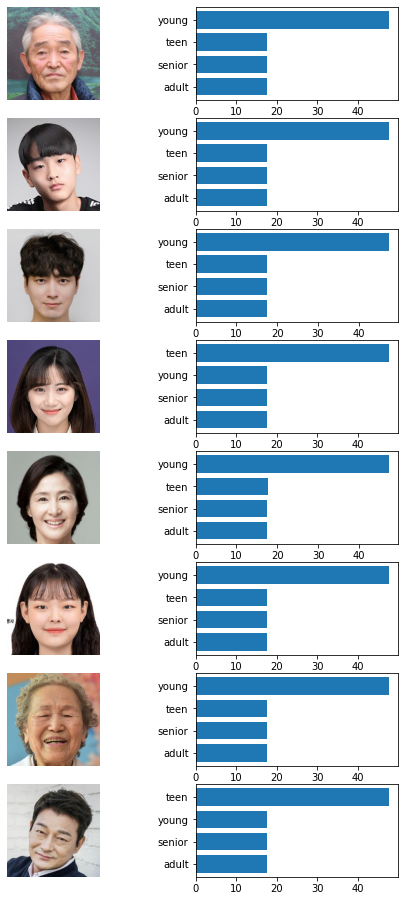

In [ ]:
#test visualization
evaluate_testdata(model_R152V2)

## Xception

### Modeling

In [ ]:
#import Xception
from keras.applications.xception import Xception

conv_base = Xception(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-VGG16
model_X = models.Sequential()
model_X.add(conv_base)

#DNN
model_X.add(layers.Flatten())
model_X.add(layers.Dense(256, activation = 'relu'))
model_X.add(layers.Dropout(0.2))
model_X.add(layers.Dense(64, activation = 'relu'))
model_X.add(layers.BatchNormalization())
model_X.add(layers.Dense(4, activation = 'softmax'))

model_X.summary()

#model compiling
from keras import optimizers

model_X.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_102 (Bat (None, 64)                256       
_______________________________________________________

In [ ]:
#model fitting 
%%time

hist_X = model_X.fit(train_data,
                 epochs = 100,
                 validation_data = valid_data)

Epoch 1/100
13/13 [==============================] - 32s 1s/step - loss: 1.7582 - accuracy: 0.2991 - val_loss: 1.3460 - val_accuracy: 0.3588
Epoch 2/100
13/13 [==============================] - 12s 912ms/step - loss: 1.4774 - accuracy: 0.3954 - val_loss: 1.3004 - val_accuracy: 0.3931
Epoch 3/100
13/13 [==============================] - 12s 899ms/step - loss: 1.3794 - accuracy: 0.4220 - val_loss: 1.2605 - val_accuracy: 0.4008
Epoch 4/100
13/13 [==============================] - 12s 882ms/step - loss: 1.3210 - accuracy: 0.4885 - val_loss: 1.2266 - val_accuracy: 0.4427
Epoch 5/100
13/13 [==============================] - 12s 873ms/step - loss: 1.1836 - accuracy: 0.5149 - val_loss: 1.1975 - val_accuracy: 0.4313
Epoch 6/100
13/13 [==============================] - 11s 915ms/step - loss: 1.0988 - accuracy: 0.5368 - val_loss: 1.1667 - val_accuracy: 0.4542
Epoch 7/100
13/13 [==============================] - 12s 875ms/step - loss: 1.1309 - accuracy: 0.5542 - val_loss: 1.1404 - val_accuracy: 0.

### Evaluation

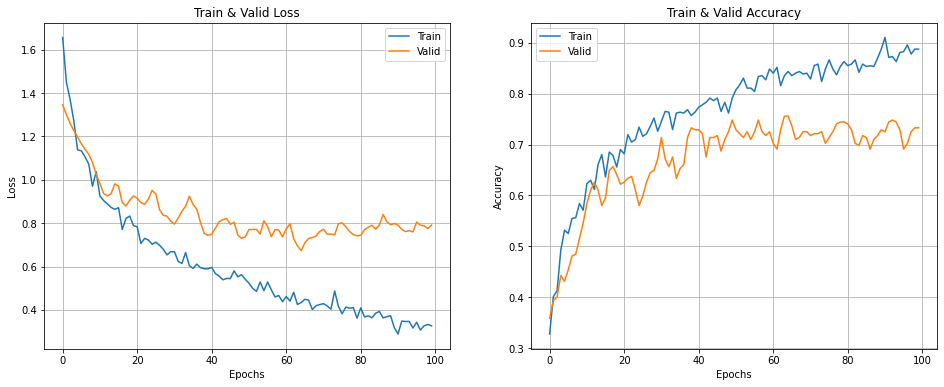

In [ ]:
#loss & accuracy visualization
draw_graph(hist_X)

In [ ]:
#model evaluation
loss_X, acc_X = model_X.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_X:.5f}')

print('\n* Accuracy')
print(f'==> {acc_X:.5f}')

6/6 [==============================] - 1s 152ms/step - loss: 0.7913 - accuracy: 0.7328

* Loss
==> 0.79131

* Accuracy
==> 0.73282


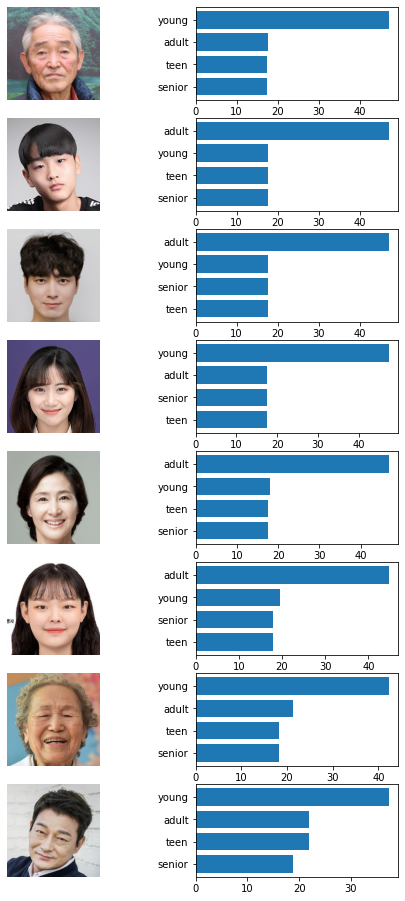

In [ ]:
#test visualization
evaluate_testdata(model_X)

## ResNet50V2

### Modeling

In [ ]:
#import ResNet50V2
from keras.applications.resnet_v2 import ResNet50V2

conv_base = ResNet50V2(include_top = False,
                     #weights = 'imagenet',
                      input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-ResNet50V2
model_R50V2 = models.Sequential()
model_R50V2.add(conv_base)

#DNN
model_R50V2.add(layers.Flatten())
model_R50V2.add(layers.Dense(256, activation = 'relu'))
model_R50V2.add(layers.Dropout(0.2))
model_R50V2.add(layers.Dense(64, activation = 'relu'))
model_R50V2.add(layers.BatchNormalization())
model_R50V2.add(layers.Dense(4, activation = 'softmax'))

model_R50V2.summary()

#model compiling
from keras import optimizers

model_R50V2.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

94683136/94668760 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_______________________________________________________

In [ ]:
#model fitting 
%%time

hist_R50V2 = model_R50V2.fit(train_data,
                 epochs = 100,
                 validation_data = valid_data)

Epoch 1/50
13/13 [==============================] - 8s 623ms/step - loss: 0.5938 - accuracy: 0.7716 - val_loss: 0.7226 - val_accuracy: 0.7176
Epoch 2/50
13/13 [==============================] - 8s 626ms/step - loss: 0.6089 - accuracy: 0.7504 - val_loss: 0.7092 - val_accuracy: 0.7137
Epoch 3/50
13/13 [==============================] - 8s 609ms/step - loss: 0.6317 - accuracy: 0.7569 - val_loss: 0.6945 - val_accuracy: 0.7137
Epoch 4/50
13/13 [==============================] - 8s 622ms/step - loss: 0.5796 - accuracy: 0.7635 - val_loss: 0.6968 - val_accuracy: 0.7099
Epoch 5/50
13/13 [==============================] - 8s 604ms/step - loss: 0.5685 - accuracy: 0.7553 - val_loss: 0.6968 - val_accuracy: 0.7176
Epoch 6/50
13/13 [==============================] - 8s 624ms/step - loss: 0.5417 - accuracy: 0.7863 - val_loss: 0.6933 - val_accuracy: 0.7252
Epoch 7/50
13/13 [==============================] - 8s 628ms/step - loss: 0.6081 - accuracy: 0.7553 - val_loss: 0.6862 - val_accuracy: 0.7176
Epoch 

### Evaluation

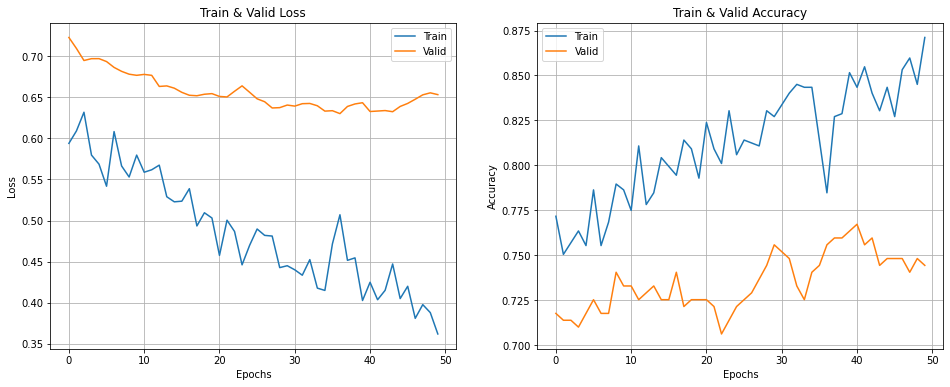

In [ ]:
#loss & accuracy visualization
draw_graph(hist_R50V2)

In [ ]:
#model evaluation
loss_R50V2, acc_R50V2 = model_R50V2.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_R50V2:.5f}')

print('\n* Accuracy')
print(f'==> {acc_R50V2:.5f}')

6/6 [==============================] - 1s 120ms/step - loss: 0.6531 - accuracy: 0.7443

* Loss
==> 0.65306

* Accuracy
==> 0.74427


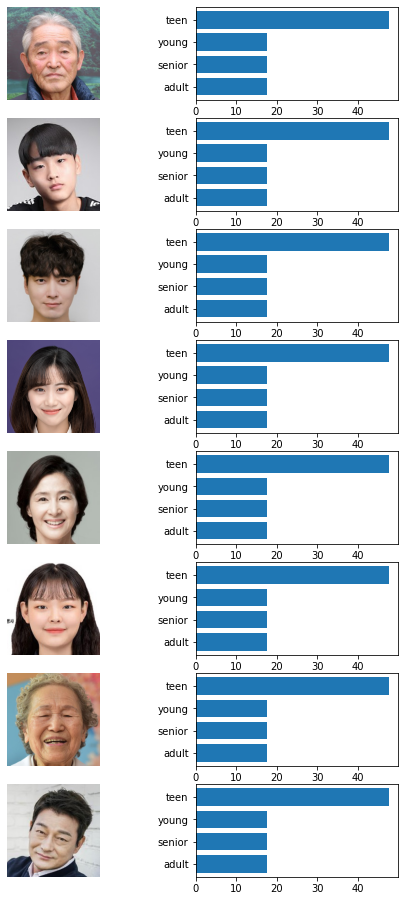

In [ ]:
#test visualization
evaluate_testdata(model_R50V2)

## ResNet50

### Modeling

In [ ]:
#import ResNet50
from keras.applications.resnet import ResNet50

conv_base = ResNet50(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-ResNet50
model_R = models.Sequential()
model_R.add(conv_base)

#DNN
model_R.add(layers.Flatten())
model_R.add(layers.Dense(256, activation = 'relu'))
model_R.add(layers.Dropout(0.2))
model_R.add(layers.Dense(64, activation = 'relu'))
model_R.add(layers.BatchNormalization())
model_R.add(layers.Dense(4, activation = 'softmax'))

model_R.summary()

#model compiling
from keras import optimizers

model_R.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_______________________________________________________

In [ ]:
#model fitting 
%%time

hist_R = model_R.fit(train_data,
                 epochs = 100,
                 validation_data = valid_data)

Epoch 1/100
13/13 [==============================] - 25s 998ms/step - loss: 1.8491 - accuracy: 0.2735 - val_loss: 1.3875 - val_accuracy: 0.4122
Epoch 2/100
13/13 [==============================] - 9s 669ms/step - loss: 1.4940 - accuracy: 0.3721 - val_loss: 1.3796 - val_accuracy: 0.2824
Epoch 3/100
13/13 [==============================] - 9s 667ms/step - loss: 1.4460 - accuracy: 0.3963 - val_loss: 1.3448 - val_accuracy: 0.4160
Epoch 4/100
13/13 [==============================] - 9s 712ms/step - loss: 1.1807 - accuracy: 0.5240 - val_loss: 1.4851 - val_accuracy: 0.4084
Epoch 5/100
13/13 [==============================] - 9s 672ms/step - loss: 1.2838 - accuracy: 0.5095 - val_loss: 1.6864 - val_accuracy: 0.4122
Epoch 6/100
13/13 [==============================] - 9s 675ms/step - loss: 1.1482 - accuracy: 0.5639 - val_loss: 1.7554 - val_accuracy: 0.4122
Epoch 7/100
13/13 [==============================] - 9s 704ms/step - loss: 1.0739 - accuracy: 0.5613 - val_loss: 1.9782 - val_accuracy: 0.194

### Evaluation

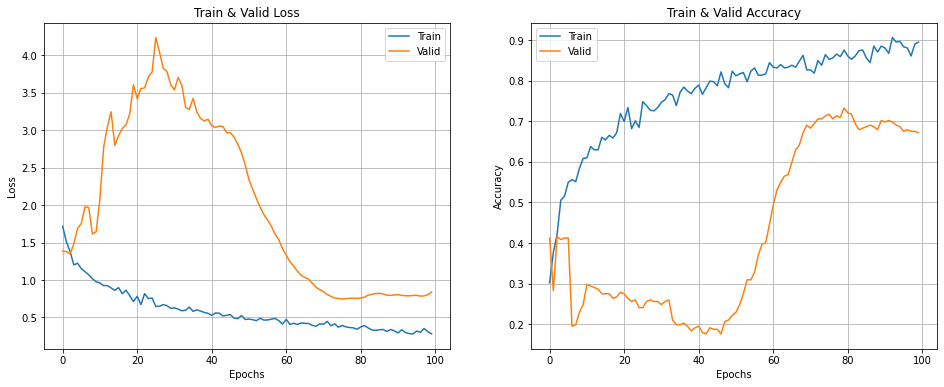

In [ ]:
#loss & accuracy visualization
draw_graph(hist_R)

In [ ]:
#model evaluation
loss_R, acc_R = model_R.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_R:.5f}')

print('\n* Accuracy')
print(f'==> {acc_R:.5f}')

6/6 [==============================] - 1s 137ms/step - loss: 0.8388 - accuracy: 0.6718

* Loss
==> 0.83881

* Accuracy
==> 0.67176


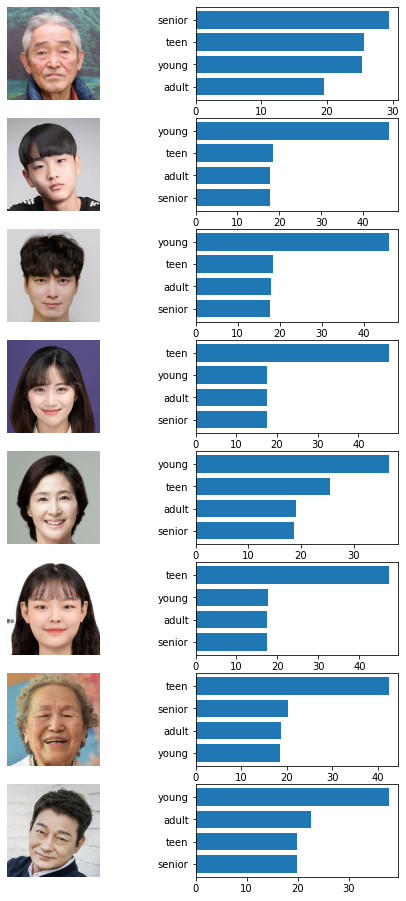

In [ ]:
#test visualization
evaluate_testdata(model_R)

## InceptionV3

### Modeling

In [ ]:
#import InceptionV3 
from keras.applications.inception_v3 import InceptionV3

conv_base = InceptionV3(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-InceptionV3
model_I = models.Sequential()
model_I.add(conv_base)

#DNN
model_I.add(layers.Flatten())
model_I.add(layers.Dense(256, activation = 'relu'))
model_I.add(layers.Dropout(0.2))
model_I.add(layers.Dense(64, activation = 'relu'))
model_I.add(layers.BatchNormalization())
model_I.add(layers.Dense(4, activation = 'softmax'))

model_I.summary()

#model compiling
from keras import optimizers

model_I.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_97 (Batc (None, 64)                256       
_______________________________________________________

In [ ]:
#model fitting 
%%time

hist_I = model_I.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

Epoch 1/50
13/13 [==============================] - 8s 573ms/step - loss: 0.6322 - accuracy: 0.7602 - val_loss: 0.9063 - val_accuracy: 0.6908
Epoch 2/50
13/13 [==============================] - 8s 618ms/step - loss: 0.6016 - accuracy: 0.7520 - val_loss: 0.9040 - val_accuracy: 0.6832
Epoch 3/50
13/13 [==============================] - 8s 578ms/step - loss: 0.6256 - accuracy: 0.7520 - val_loss: 0.9226 - val_accuracy: 0.6603
Epoch 4/50
13/13 [==============================] - 8s 582ms/step - loss: 0.6171 - accuracy: 0.7602 - val_loss: 0.9246 - val_accuracy: 0.6565
Epoch 5/50
13/13 [==============================] - 8s 579ms/step - loss: 0.6465 - accuracy: 0.7455 - val_loss: 0.9353 - val_accuracy: 0.6565
Epoch 6/50
13/13 [==============================] - 8s 577ms/step - loss: 0.6103 - accuracy: 0.7651 - val_loss: 0.9519 - val_accuracy: 0.6565
Epoch 7/50
13/13 [==============================] - 8s 578ms/step - loss: 0.6025 - accuracy: 0.7798 - val_loss: 0.9694 - val_accuracy: 0.6489
Epoch 

### Evaluation

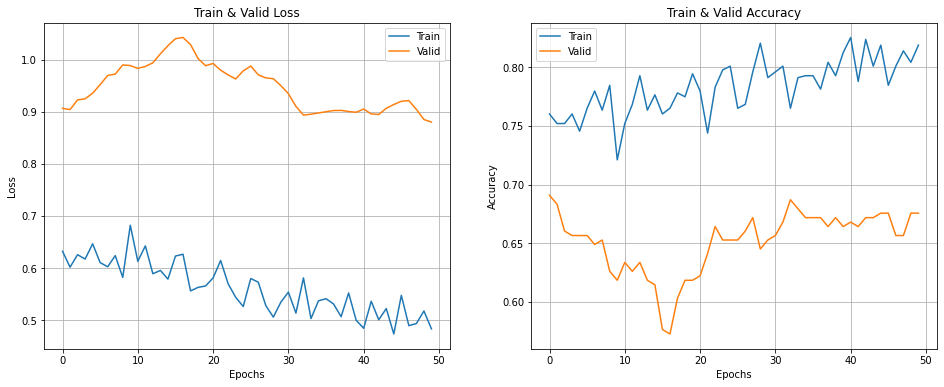

In [ ]:
#loss & accuracy visualization
draw_graph(hist_I)

In [ ]:
#model evaluation
loss_I, acc_I = model_I.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_I:.5f}')

print('\n* Accuracy')
print(f'==> {acc_I:.5f}')

6/6 [==============================] - 1s 83ms/step - loss: 0.8800 - accuracy: 0.6756

* Loss
==> 0.88000

* Accuracy
==> 0.67557


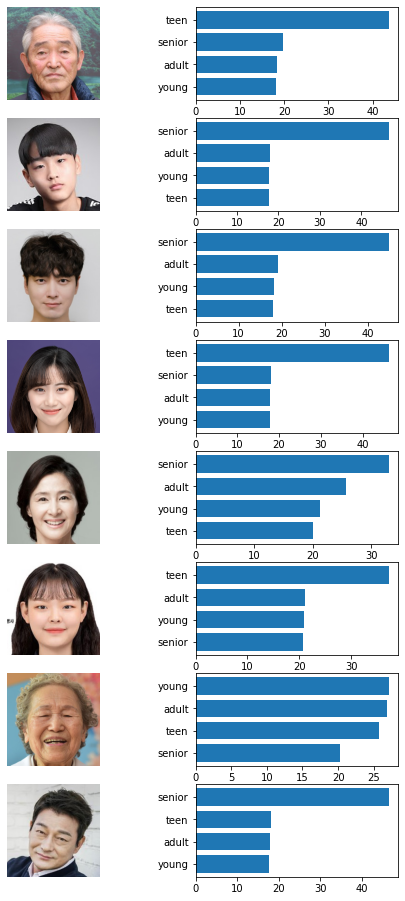

In [ ]:
#test visualization
evaluate_testdata(model_I)

## ResNet101

### Modeling

In [ ]:
#import ResNet101
from keras.applications.resnet import ResNet101

conv_base = ResNet101(include_top = False,
                       input_shape = (200,200,3))

#model definition
from keras import models, layers, regularizers

#CNN-ResNet50
model_R101 = models.Sequential()
model_R101.add(conv_base)

#DNN
model_R101.add(layers.Flatten())
model_R101.add(layers.Dense(256, activation = 'relu'))
model_R101.add(layers.Dropout(0.2))
model_R101.add(layers.Dense(64, activation = 'relu'))
model_R101.add(layers.BatchNormalization())
model_R101.add(layers.Dense(4, activation = 'softmax'))

model_R101.summary()

#model compiling
from keras import optimizers

model_R101.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_209 (Bat (None, 64)                256       
_________________________________________________________________
dense_20 (Dense)             (None, 4)                

In [ ]:
#model fitting 
%%time

hist_R101 = model_R101.fit(train_data,
                 epochs = 100,
                 validation_data = valid_data)

Epoch 1/50
13/13 [==============================] - 43s 2s/step - loss: 1.8373 - accuracy: 0.2620 - val_loss: 1.8528 - val_accuracy: 0.1412
Epoch 2/50
13/13 [==============================] - 12s 932ms/step - loss: 1.7626 - accuracy: 0.2887 - val_loss: 2.2230 - val_accuracy: 0.1489
Epoch 3/50
13/13 [==============================] - 13s 944ms/step - loss: 1.4907 - accuracy: 0.3984 - val_loss: 2.5834 - val_accuracy: 0.1718
Epoch 4/50
13/13 [==============================] - 12s 925ms/step - loss: 1.3493 - accuracy: 0.4966 - val_loss: 4.5026 - val_accuracy: 0.1565
Epoch 5/50
13/13 [==============================] - 12s 916ms/step - loss: 1.3027 - accuracy: 0.4915 - val_loss: 3.5312 - val_accuracy: 0.1718
Epoch 6/50
13/13 [==============================] - 12s 910ms/step - loss: 1.1905 - accuracy: 0.5039 - val_loss: 3.4249 - val_accuracy: 0.1794
Epoch 7/50
13/13 [==============================] - 12s 911ms/step - loss: 1.2447 - accuracy: 0.4876 - val_loss: 4.3584 - val_accuracy: 0.1756
Ep

KeyboardInterrupt: ignored

### Evaluation

In [ ]:
#loss & accuracy visualization
draw_graph(hist_R101)

In [ ]:
#model evaluation
loss_R101, acc_R101 = model_R101.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss_R101:.5f}')

print('\n* Accuracy')
print(f'==> {acc_R101:.5f}')

In [ ]:
#test visualization
evaluate_testdata(model_R101)

## Result


In [ ]:
import pandas as pd

result = pd.DataFrame(data = {'Name' : ['VGG16','VGG19','ResNet50','ResNet101','ResNet152','ResNet50V2','ResNet101V2','ResNet152V2','DenseNet121','DenseNet169','DenseNet201','Xception','InceptionV3','InceptionResNetV2'],
                              'Accuracy' : [acc_V, acc_V19, acc_R, acc_R101, acc_R152, acc_R50V2, acc_R101V2, acc_R152V2, acc_D121, acc_D169, acc_D201, acc_X, acc_I, acc_IR]})

result = result.sort_values(by = ['Accuracy'], ascending = False)
result

In [ ]:
#Accuracy 순위대로 표시
import seaborn as sns

plt.figure(figsize = (24,8))
sns.barplot(data = result, x = 'Name', y = 'Accuracy')

plt.show()

### Model selection
- loss와 accuracy, 그리고 test evaluation을 종합하여 비교한 결과 VGG16, VGG19, DenseNet201을 선정하였습니다.

### Model saving

In [ ]:
model_names = ['model_V', 'model_V19', 'model_D201']

model_list = [model_V, model_V19, model_D201]

for name, model in zip(model_names, model_list):
    try:
        json = model.to_json()
    except:
        continue

    model.save(f"/content/drive/My Drive/[양재] 1조/models/{name}.h5")
    with open(f"/content/drive/My Drive/[양재] 1조/models/{name}.json", "w") as json_file :
        json_file.write(json)